In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.models.svm import *
from jaxl.plot_utils import set_size
from jaxl.utils import parse_dict

import _pickle as pickle
import copy
import jax
import jax.numpy as jnp
import jax.random as jrandom
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import optax
import os

from functools import partial
from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

plt.style.use("seaborn")

/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_13941/576108631.py:23: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
baseline_path = "/Users/chanb/research/personal/jaxl/scripts/icl/results-num_tasks_30-seq_len_8-seed_9999-10-05-23_12_51_15"

base_dir = "/Users/chanb/research/personal/jaxl/jaxl"
# latest
# rel_path = "logs/icl-sigmoid_bce-context_len_8/default-10-02-23_12_27_47-6931fa19-ee8f-4fb2-ab41-0d96b7b17da2"
# rel_path = "logs/icl-sigmoid_bce-context_len_8/unfrozen-10-02-23_12_27_50-9d90434c-2d13-4317-b34a-bb55cd6f62b2"
# rel_path = "logs/icl-sigmoid_bce-context_len_8/all_ones-10-02-23_12_27_52-c1fa225e-2b8d-4a9a-8971-ba9e41cdf68c"
rel_path = "logs/icl-sigmoid_bce-context_len_8/one_hot-10-02-23_12_27_56-4a14d899-63f6-4afc-b864-5ef22c51a32f"

# larger arch
# rel_path = "logs/icl-sigmoid_bce-context_len_8-large_arch/default-10-04-23_17_34_52-aa4fa4c8-db6a-4dd4-b91d-64d72b8b56a8"
# rel_path = "logs/icl-sigmoid_bce-context_len_8-large_arch/all_ones-10-04-23_17_34_55-dbeed583-fe53-417e-9c7d-4f712dae126e"
# rel_path = "logs/icl-sigmoid_bce-context_len_8-large_arch/one_hot-10-04-23_17_35_06-e36233bc-9649-4434-afa3-1e218a145e71/"

learner_path = os.path.join(base_dir, rel_path)

# For plotting
doc_width_pt = 1000.0

# Helper Functions

In [3]:
def load_llm(learner_path: str):
    config_path = os.path.join(learner_path, "config.json")
    with open(config_path, "r") as f:
        config_dict = json.load(f)
        config = parse_dict(config_dict)

    learner = get_learner(
        config.learner_config, config.model_config, config.optimizer_config
    )

    checkpoint_manager = CheckpointManager(
        os.path.join(learner_path, "models"),
        PyTreeCheckpointer(),
    )

    llm_params = checkpoint_manager.restore(checkpoint_manager.latest_step())
    llm_params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
    llm_model = learner._model
    return llm_params, llm_model, config


def get_agent_repr(context_data, queries, agent_path, use_input_token_repr=False):
    llm_params, llm_model, _ = load_llm(agent_path)

    agent_result = {}
    for task_i in context_data:
        context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
        context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]

        if queries is None:
            queries = context_inputs

        repr, _ = jax.vmap(llm_model.get_latent, in_axes=[None, 0, None])(
            llm_params[CONST_MODEL_DICT][CONST_MODEL],
            queries[:, None, None],
            {
                CONST_CONTEXT_INPUT: context_inputs[None],
                CONST_CONTEXT_OUTPUT: context_outputs[None],
            },
        )

        if use_input_token_repr:
            agent_result[task_i] = repr[0, 0, :-1:2]
        else:
            agent_result[task_i] = repr[:, 0, -1]
    return agent_result

# Check SVM in Representation Space

In [4]:
# Load dataset
context_data = pickle.load(
    open(os.path.join(baseline_path, "context_data.pkl"), "rb")
)

gt = pickle.load(
    open(os.path.join(baseline_path, "ground_truth.pkl"), "rb")
)

config = pickle.load(
    open(os.path.join(baseline_path, "config.pkl"), "rb")
)
input_range = config["input_range"]

llm_params, llm_model, _ = load_llm(learner_path)
context_reprs = get_agent_repr(context_data, None, learner_path)
input_token_context_reprs = get_agent_repr(context_data, None, learner_path, use_input_token_repr=True)
query_reprs = get_agent_repr(context_data, gt["inputs"], learner_path)

In [20]:
svm_results = {}
for task_i, task_repr in context_reprs.items():
    svm_results.setdefault(task_i, {})
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]

    train_y = np.argmax(context_outputs, axis=-1)
    train_y[train_y == 0] = -1

    loss, sol = primal_svm(context_inputs, train_y)
    svm_results[task_i]["primal_input"] = {
        "loss": loss,
        "sol": sol,
    }

    loss, sol = primal_svm(task_repr, train_y)
    svm_results[task_i]["primal_repr"] = {
        "loss": loss,
        "sol": sol,
    }

    loss, sol = dual_svm(context_inputs, train_y)
    svm_results[task_i]["dual_input"] = {
        "loss": loss,
        "sol": sol,
    }

    loss, sol = dual_svm(task_repr, train_y)
    svm_results[task_i]["dual_repr"] = {
        "loss": loss,
        "sol": sol,
    }

In [21]:
from pprint import pprint

pprint(svm_results)

{0: {'dual_input': {'loss': 5.4351869890105196,
                    'sol': array([-9.06032359e-23,  5.43518699e+00,  1.65993126e-22, -2.37357149e-22,
        3.70474009e+00,  5.52581478e-22,  1.73044690e+00, -1.67993753e-23])},
     'dual_repr': {'loss': 0.003445136066210367,
                   'sol': array([-1.90284961e-25,  4.84881422e-25,  3.44513607e-03,  3.44513607e-03,
       -4.99490538e-25, -3.55856601e-25, -1.23982929e-24,  8.32253891e-25])},
     'primal_input': {'loss': 5.43518698901052,
                      'sol': array([ 2.93401233, -1.5039766 ,  0.18299436])},
     'primal_repr': {'loss': 0.003445136211619276,
                     'sol': array([ 0.08108883, -0.0056192 , -0.00107717, -0.00185317, -0.00127107,
        0.00105068, -0.00433568, -0.00281708,  0.00143486, -0.00340668,
       -0.00253179, -0.00509801,  0.00172839, -0.0033528 , -0.00161875,
        0.00058268,  0.00339685, -0.00086196, -0.00625785,  0.00050672,
        0.00300097, -0.0003882 , -0.00182886, -0.00

In [22]:
for task_i, task_repr in context_reprs.items():
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)
    train_y[train_y == 0] = -1

    # XXX: Recover primal solutions from dual on input space
    dual_sol_input = svm_results[task_i]["dual_input"]["sol"]
    recovered_weights = np.sum((dual_sol_input * train_y)[:, None] * context_inputs, axis=0)

    support_vector_index = np.where(np.abs(dual_sol_input) > 1e-10)[0][0]
    recovered_bias = train_y[support_vector_index] - np.dot(
        recovered_weights, context_inputs[support_vector_index]
    )
    if not (np.allclose(
        svm_results[task_i]["primal_input"]["sol"],
        np.array([*recovered_weights, recovered_bias])
    )):
        print(task_i)

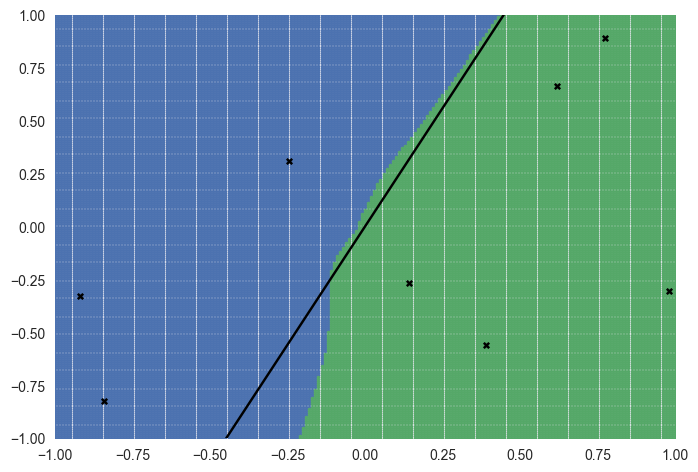

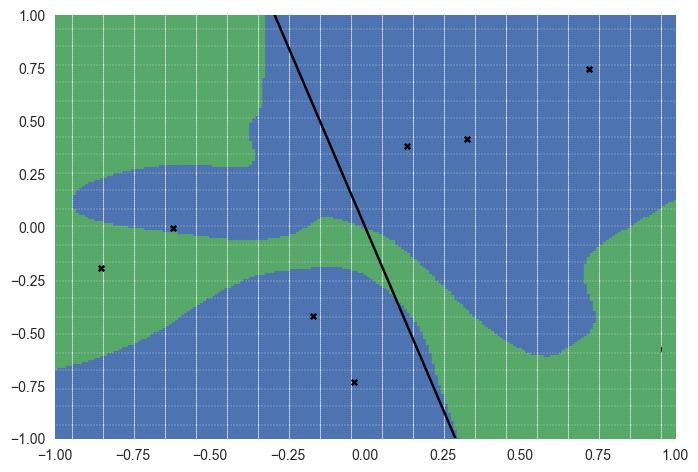

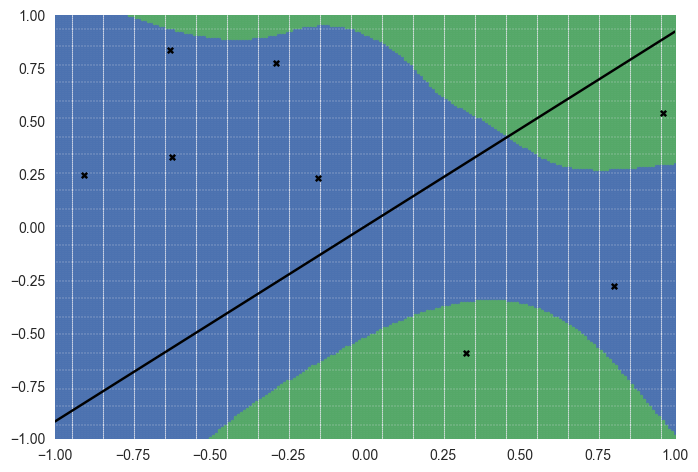

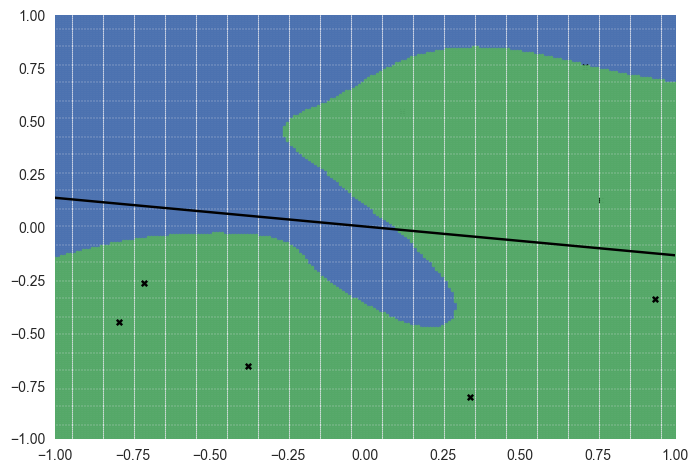

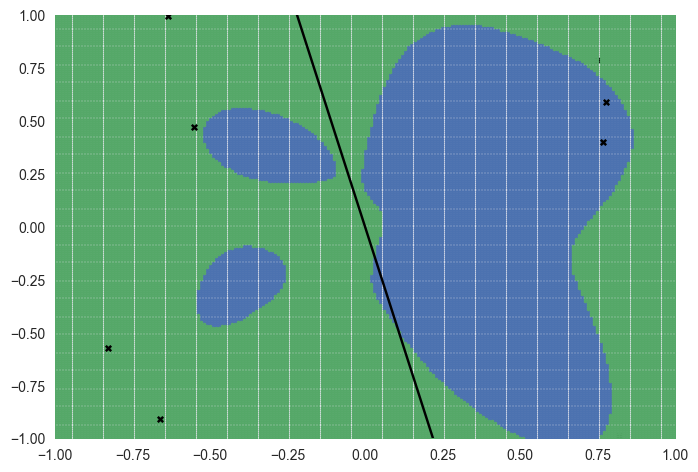

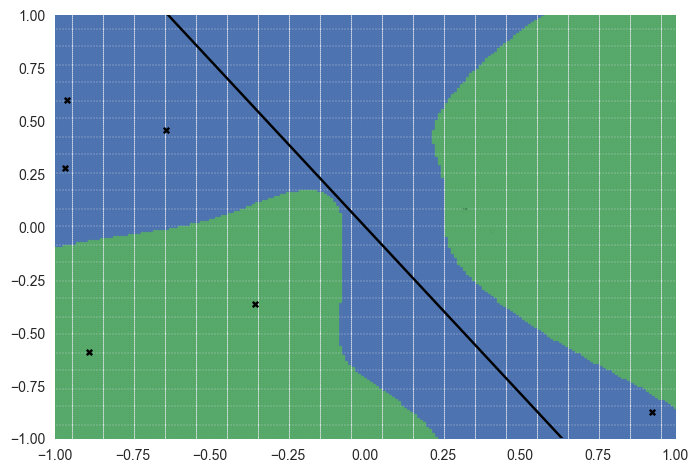

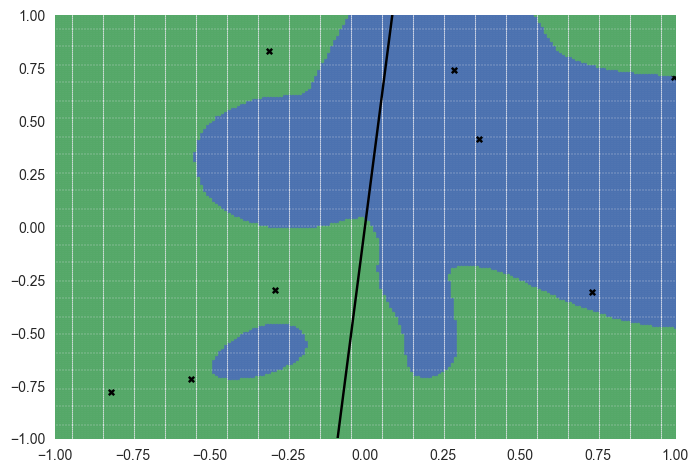

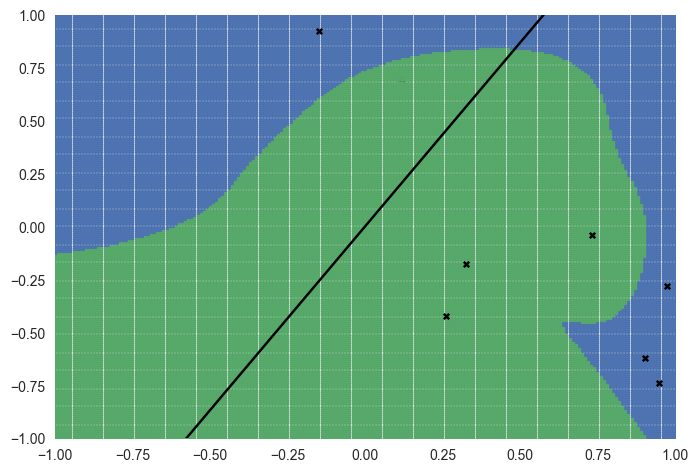

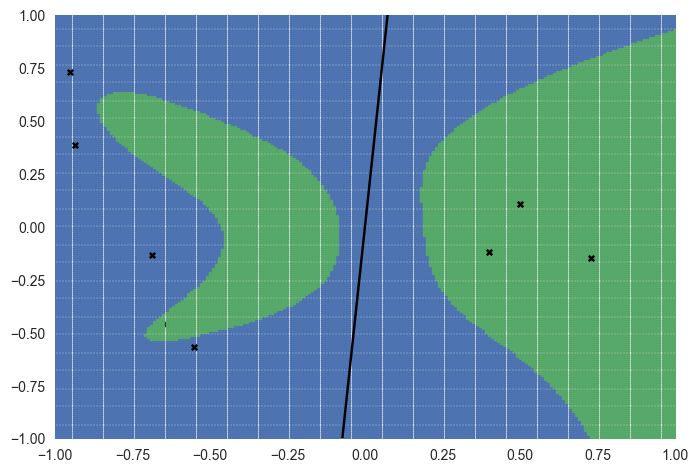

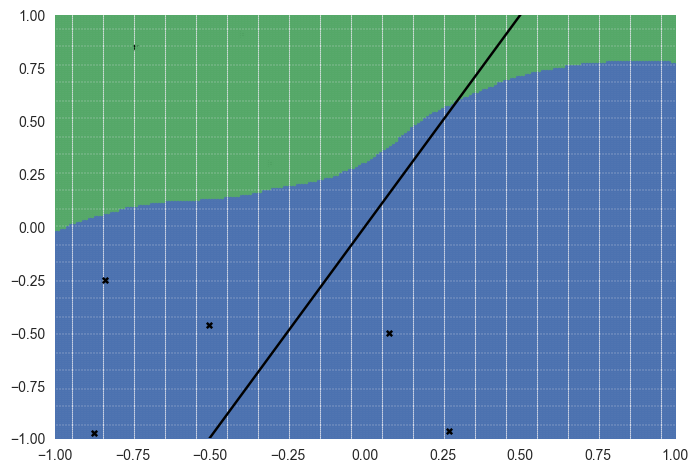

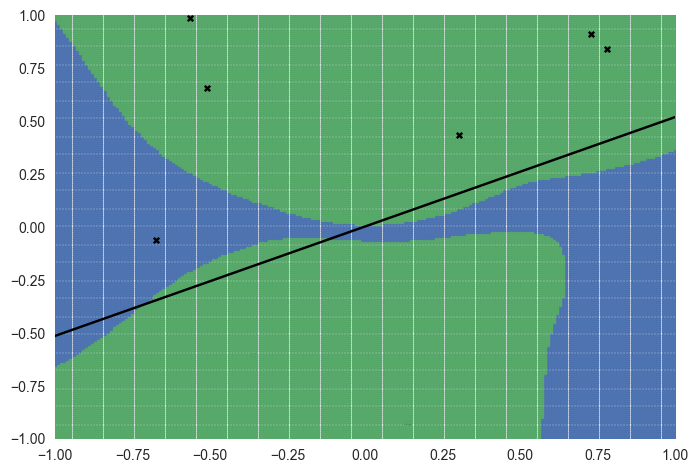

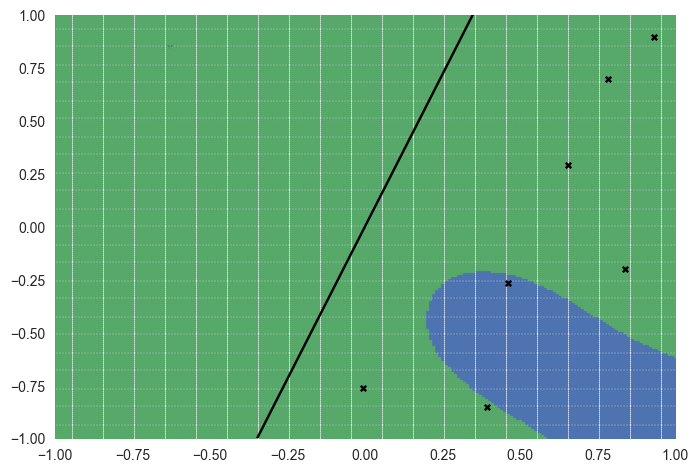

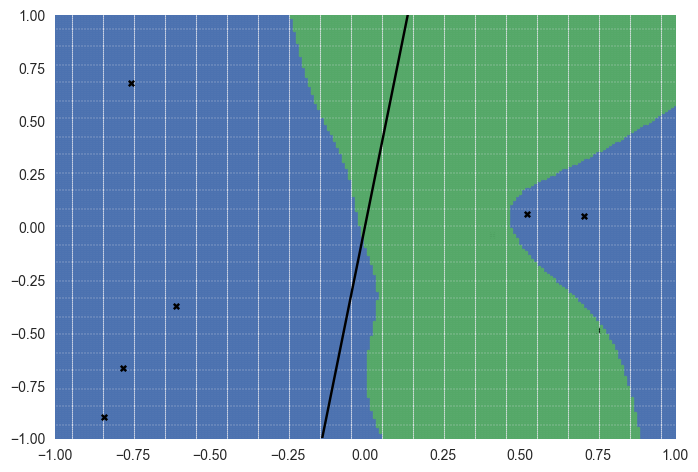

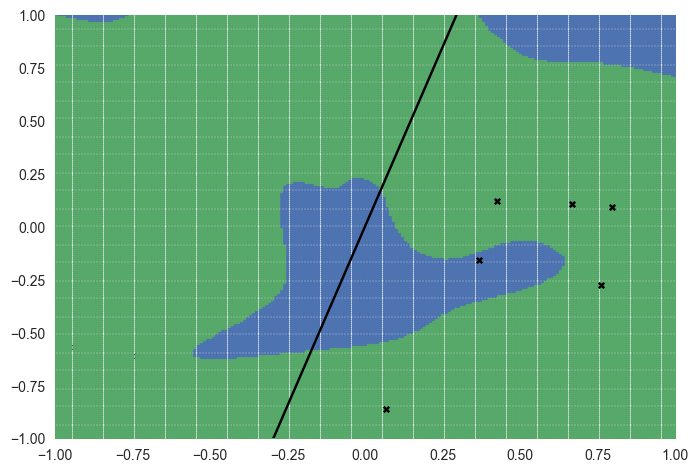

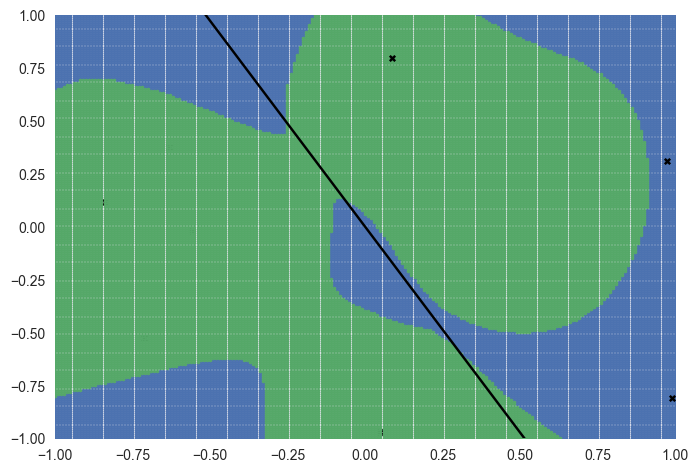

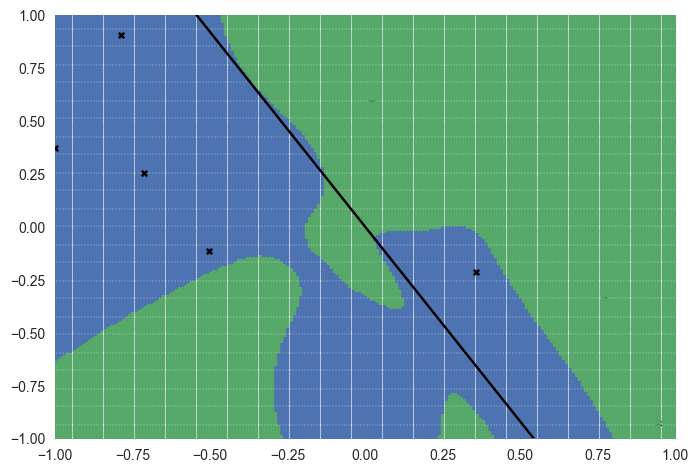

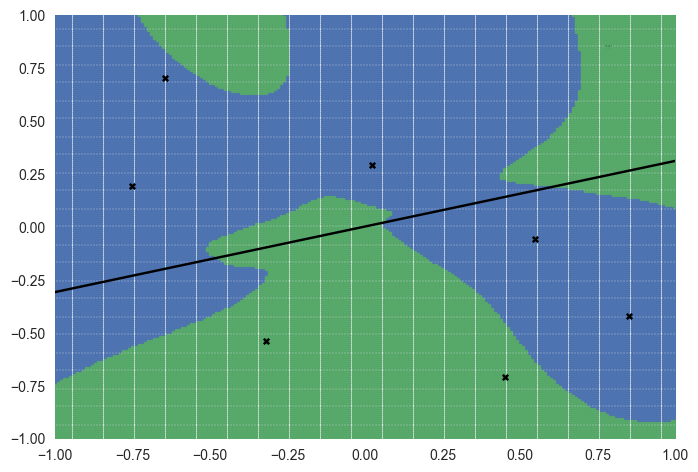

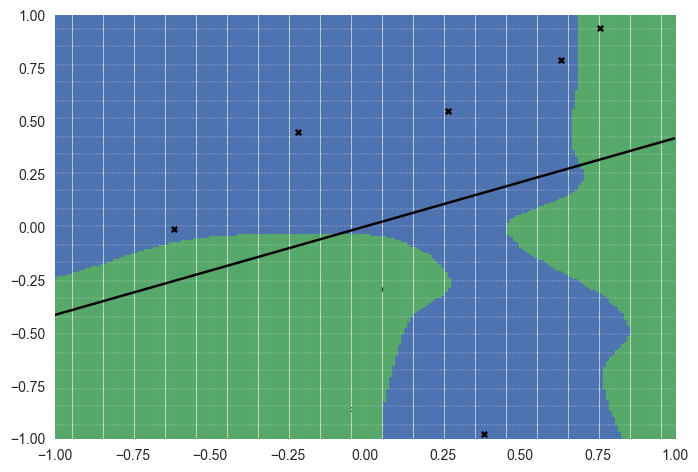

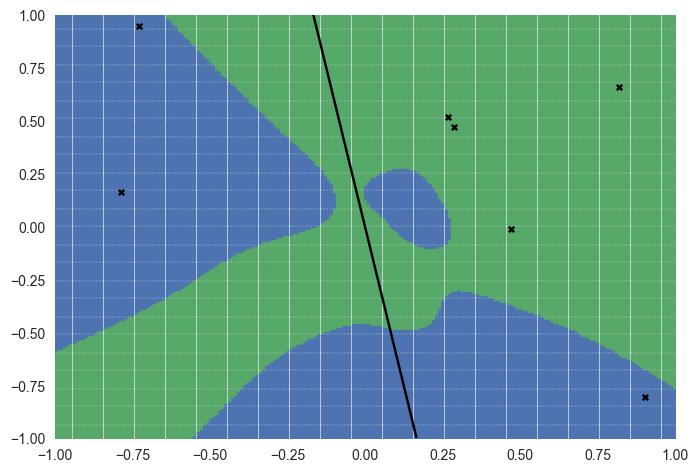

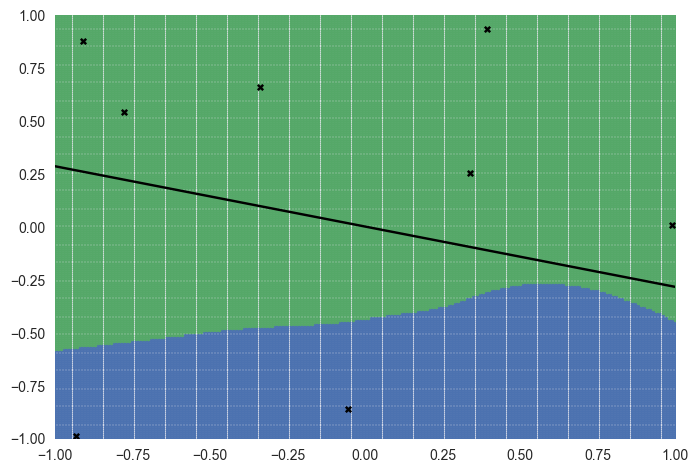

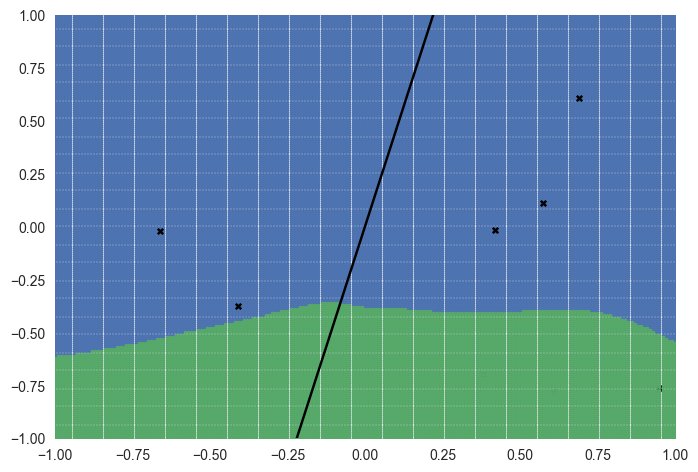

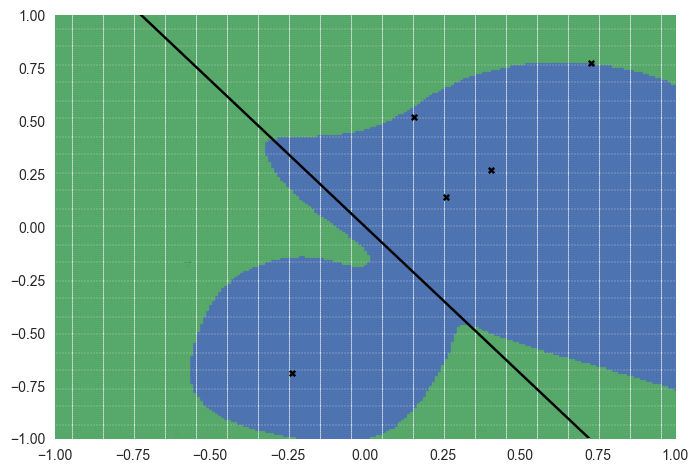

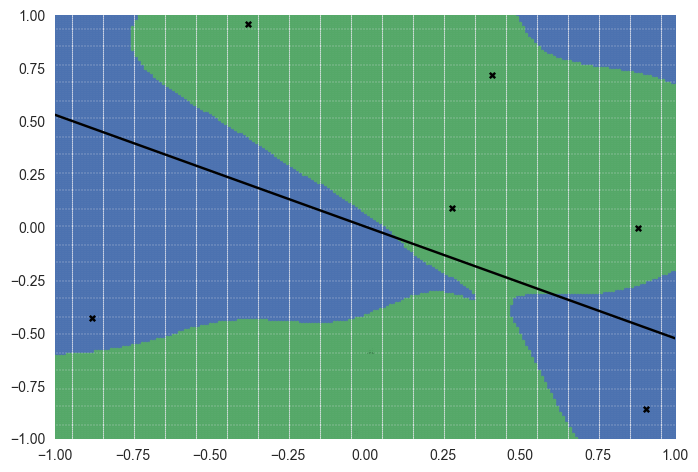

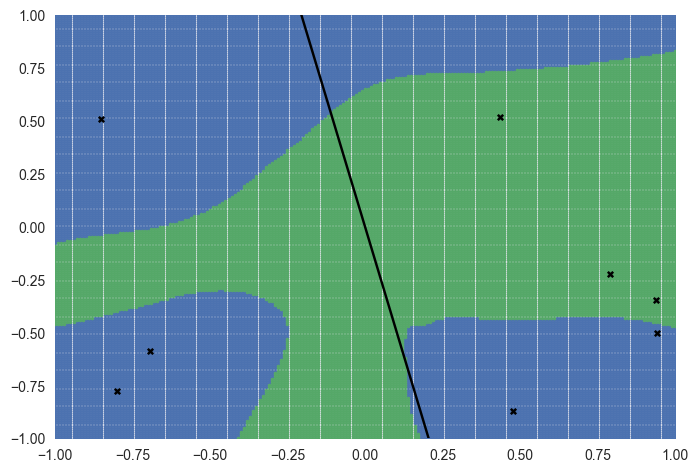

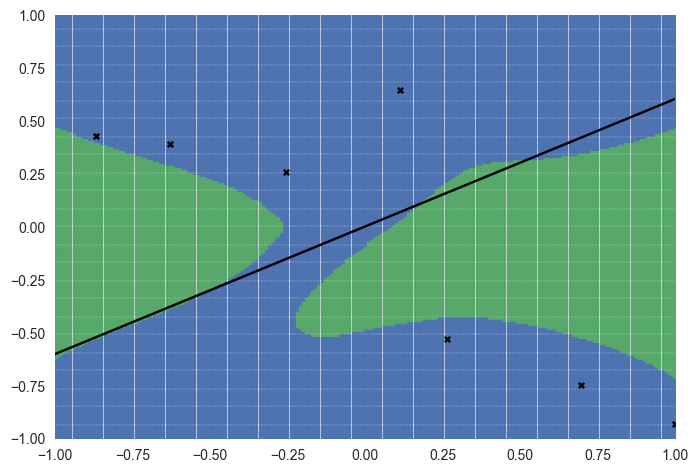

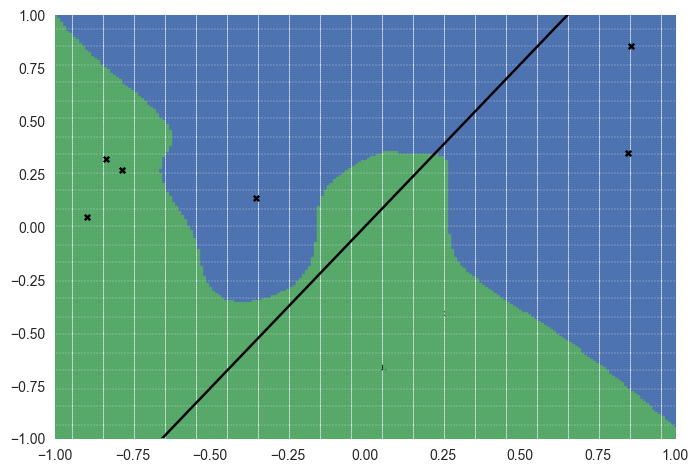

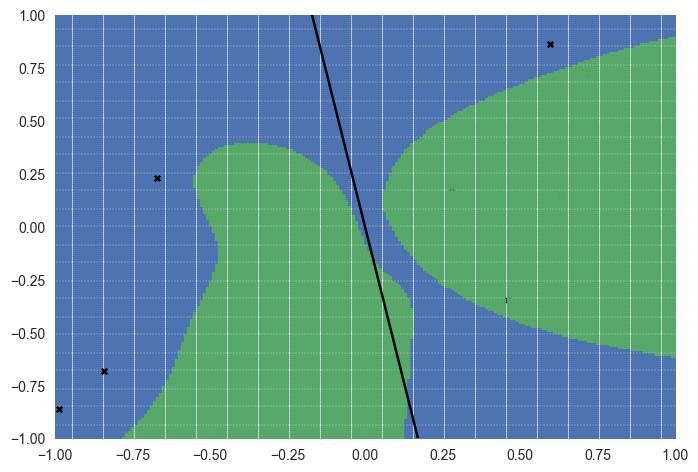

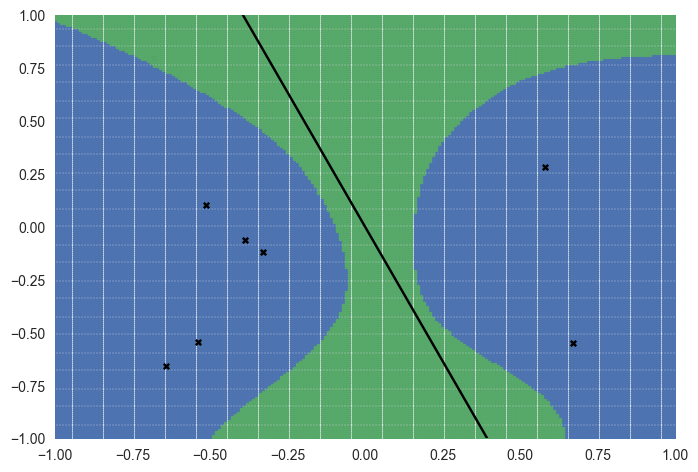

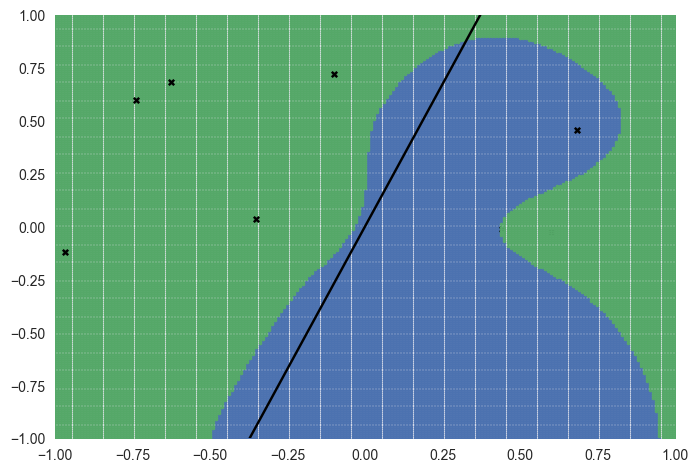

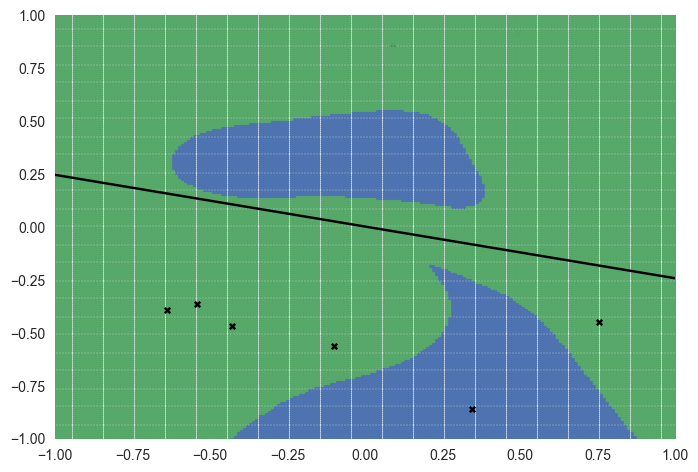

In [23]:
for task_i, task_repr in query_reprs.items():
    context_inputs = context_data[task_i][CONST_CONTEXT_INPUT]
    context_outputs = context_data[task_i][CONST_CONTEXT_OUTPUT]
    train_y = np.argmax(context_outputs, axis=-1)

    params = svm_results[task_i]["primal_repr"]["sol"]
    svm_preds = (
        (
            task_repr @ params[:-1]
            + params[-1:]
        )
        >= 0
    ).astype(int)
    
    for possible_label in [0, 1]:
        idxes = np.where(svm_preds == possible_label)
        plt.scatter(
            gt["inputs"][idxes][:, 0],
            gt["inputs"][idxes][:, 1],
            label=f"{possible_label}",
            s=5,
        )
        idxes = np.where(train_y == possible_label)
        plt.scatter(
            context_inputs[idxes][:, 0],
            context_inputs[idxes][:, 1],
            label=f"{possible_label}",
            s=15,
            marker="x",
            c="black"
        )
    plt.plot(input_range, gt["decision_boundary"][task_i], color="black")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

Recover the primal parameters from the dual derived in representation space

In [9]:
recovered_weights = np.sum((dual_sol_repr * train_y)[:, None] * context_inputs, axis=0)

support_vector_index = np.where(np.abs(dual_sol_repr) > 1e-10)[0][0]
recovered_bias = train_y[support_vector_index] - np.dot(
    recovered_weights, context_inputs[support_vector_index]
)
print(*recovered_weights, recovered_bias)

NameError: name 'dual_sol_repr' is not defined

Compare the dual parameters from the input and representation spaces

In [ ]:
print(dual_sol_input)
print(dual_sol_repr)

In [ ]:
if not use_sigmoid:
    (
        params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][:, 0]
        - params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][
            :, 1
        ]
    )

In [ ]:
primal_sol_repr

Distance of primal parameters

In [ ]:
if not use_sigmoid:
    np.linalg.norm(
        params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][:, 0]
        - params[CONST_MODEL_DICT][CONST_MODEL][CONST_PREDICTOR]["params"]["kernel"][
            :, 1
        ]
        - primal_sol_repr[:-1]
    )